In [1]:
import pandas as pd, numpy as np, pymc as pm

In [2]:
import matplotlib.pyplot as plt

- pull in age x sex structure for a specific block

- pull in decennial hh sizes
- assign arbitrary hhids, relationships

- run mcmc

# Test out household structure assignment with mcmc

Objective: given a synthetic dataset that contains, for each individual, their census block, precise age, sex, and precise race, assign a realistic household structure (wrt household ids and relationships to head of household) using distributions from the 2010 decennial.

## pull in data

This is synthetic data; it was generated using the 2010 decennial and the 2018 acs (should switch to 2010)

It has fairly accurate age, sex, and race distribution for each census block. The relationship and ethnicity (hispanic binary) columns are bad, because they are informed only by the state-level distribution of each var from the ACS. We will scrap those relationship assigments and reassign them using MCMC and the block-level decennial data. The inaccuracy of the ethnicity still needs to be addressed.

In [ ]:
## pull in age-sex structure for a single block
df = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/ravenna_07_14_2020.csv')
df.head()

In [4]:
## pull in df to fit to from decennial
input_dir = '/home/j/temp/beatrixh/sim_science/decennial_census_2010/'
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']
household_sizes = ['P02800' + ('00' + str(i))[-2:] for i in np.arange(1,17)]
relations_present = ['P02900' + ('00' + str(i))[-2:] for i in np.arange(1,29)]
household_type = ['P03000' + ('00' + str(i))[-2:] for i in np.arange(1,14)]

In [5]:
# this is the 2010 decennial for a single block in ravenna
ravenna = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/decennial_ravenna_07_20_2020.csv')

## prep vars of interest

Decennial var labels from https://www2.census.gov/programs-surveys/decennial/2010/technical-documentation/complete-tech-docs/summary-file/sf1.pdf?#

In [6]:
#relationship to head of hh
relp_labels = ['total', 'in_households', 'in_family_households',
               'householders_family', 'male_householder_family', 
               'female_householder_family', 'spouse', 'biological_child',
               'adopted_child', 'stepchild', 'grandchild', 'sibling', 
               'parent', 'parent_in_law', 'child_in_law', 
               'other_relatives', 'nonrelatives', 
               'in_nonfamily_households', 
               'male_householder_nonfamily','male_householder_nonfamily_alone','male_householder_nonfamily_not_alone', 
               'female_householder_nonfamily', 'female_householder_nonfamily_alone','female_householder_nonfamily_not_alone', 
               'nonrelatives_nonfamily',
               'in_gq','gq_inst','gq_noninst']

ravenna_relps = ravenna[relations_present].melt(value_name = 'counts', var_name = 'relp')
ravenna_relps['decennial_relp'] = relp_labels

#these will be onto and mutually exclusive, but not 1:1 or defined on the entire domain
decennial_acs_relp_dict = {'householders_family':0,
                           'male_householder_nonfamily':0,
                           'female_householder_nonfamily':0,
                           'spouse':1,
                          'biological_child':2,
                          'adopted_child':3,
                          'stepchild':4,
                          'sibling':5,
                          'parent':6,
                          'grandchild':7,
                          'parent_in_law':8,
                          'child_in_law':9,
                          'other_relatives':10,
                          'nonrelatives':15, #refine this 
                          'nonrelatives_nonfamily':15, #refine this
                          'gq_inst':16,
                          'gq_noninst':17} #same-sex spouses were mapped to nonrelatives

ravenna_relps['relp_id'] = ravenna_relps.decennial_relp.map(decennial_acs_relp_dict)
ravenna_relps = ravenna_relps[ravenna_relps.relp_id.notna()]
# ravenna_relps = ravenna_relps.drop(columns=['relp','decennial_relp'])
# ravenna_relps = ravenna_relps.groupby('relp_id').sum().reset_index()

In [7]:
## household type
hh_type_labels = ['total','in_family_hh',
                  'in_husband_wife_family',
                  'in_other_family','in_male_head_no_wife',
                  'in_female_head_no_husband','in_non_family',
                  'non_family_male_head','non_family_male_head_alone',
                  'non_family_male_head_not_alone',
                  'non_family_female_head','non_family_female_head_alone',
                  'non_family_female_head_not_alone']

ravenna_hh_types = ravenna[household_type].melt(value_name = 'counts', var_name = 'hh_type')
ravenna_hh_types['hh_type_label'] = hh_type_labels

In [8]:
## household ids
ravenna_hhs = ravenna[household_sizes].melt(value_name = 'counts', var_name = 'hh_size')

## map census vars to household sizes
d = {}
d.update({i:int(i[-1])-1 for i in ravenna.columns[8:14]})
d.update({i:int(i[-1])+1 for i in ravenna.columns[15:]})

ravenna_hhs['hh_size'] = ravenna_hhs.hh_size.map(d)
ravenna_hhs = ravenna_hhs[ravenna_hhs.hh_size.notna()]
ravenna_hhs = ravenna_hhs.groupby('hh_size').sum().reset_index()

In [9]:
n_households = ravenna_hhs['counts'].sum()
n_sims = df.pweight.sum()

print(f'''n_households: {n_households}
n_simulants: {n_sims}''')

n_households: 24
n_simulants: 65


## mcmc

initialize with uniform priors, then add in constraints using decennial block-level data

In [10]:
hhid = pm.DiscreteUniform('hhid', 0, n_households-1, size=n_sims)
relp = pm.DiscreteUniform('relp', 0, ravenna_relps.relp_id.max(), size = n_sims)
family_hh = pm.DiscreteUniform('family_hh', 0, 1, size = n_sims)

In [11]:
#make sure there are exactly n_households hhs
@pm.potential
def hh_count_constraint_soft(hhid=hhid, n_households=n_households):
    diff = len(np.unique(hhid)) - n_households
    return -1*(diff)**2

In [12]:
def checkout_hh_count_constraint_soft(hhid=hhid.value, n_households=n_households):
    diff = len(np.unique(hhid)) - n_households
    print(f'difference in number of unique households: {diff}')

In [13]:
#constrain towards correct houshold sizes
@pm.potential
def hh_size_distribution_constraint_soft(hhid=hhid, target=ravenna_hhs):
    #count hh_size distribution in sim data
    sim_hh_sizes = pd.DataFrame({'hhids':hhid}).hhids.value_counts().value_counts()
    sim_hh_sizes = pd.DataFrame(sim_hh_sizes).reset_index().rename(columns={'index':'hh_size','hhids':'sim_counts'})
    
    #compare to target distribution
    compare = sim_hh_sizes.merge(target, on = 'hh_size', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return -compare.abs_diff.sum()

In [14]:
def checkout_hh_size_distribution_constraint_soft(hhid=hhid.value, target=ravenna_hhs):
    #count hh_size distribution in sim data
    sim_hh_sizes = pd.DataFrame({'hhids':hhid}).hhids.value_counts().value_counts()
    sim_hh_sizes = pd.DataFrame(sim_hh_sizes).reset_index().rename(columns={'index':'hh_size','hhids':'sim_counts'})
    
    #compare to target distribution
    compare = sim_hh_sizes.merge(target, on = 'hh_size', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return compare.sort_values('hh_size')

In [15]:
#constrain towards correct relationship assignment distribution
@pm.potential
def relp_distribution_constraint_soft(relp=relp, target = ravenna_relps):
    #count relp distribution in sim data
    sim_relps = pd.DataFrame({'relps':relp}).relps.value_counts()
    sim_relps = pd.DataFrame(sim_relps).reset_index().rename(columns={'index':'relp_id','relps':'sim_counts'})

    #compare to target distribution
    compare = sim_relps.merge(ravenna_relps, on='relp_id', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return -target.shape[0]*compare.abs_diff.sum()

In [16]:
def checkout_relp_distribution_constraint_soft(relp=relp.value, target = ravenna_relps):
    #count relp distribution in sim data
    sim_relps = pd.DataFrame({'relps':relp}).relps.value_counts()
    sim_relps = pd.DataFrame(sim_relps).reset_index().rename(columns={'index':'relp_id','relps':'sim_counts'})

    #compare to target distribution
    compare = sim_relps.merge(ravenna_relps, on='relp_id', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return compare.sort_values('relp_id')

In [17]:
#make sure there are exactly n_households hh_heads
@pm.potential
def hh_head_count_constraint_soft(relp=relp, n_households=n_households):
    diff = sum([i==0 for i in relp]) - n_households
    return -1*(diff)**2

In [18]:
def checkout_hh_head_count_constraint_soft(relp=relp.value, n_households=n_households):
    diff = sum([i==0 for i in relp]) - n_households
    print(f'difference in number of household heads: {diff}')

In [19]:
#make sure one hh_head per hhid
@pm.potential
def one_head_per_hh_soft_constraint(relp=relp, hhid=hhid):
    #count hh_heads
    hh_heads = [1 if i==0 else 0 for i in relp]
    
    #enumerate per hhid
    heads_per_hh = pd.DataFrame({'hhid':hhid,'hh_head':hh_heads})
    heads_per_hh = heads_per_hh.groupby('hhid').sum()
    
    #look at how far from 1 per hh each is
    heads_per_hh.hh_head -= 1
    
    return -sum(heads_per_hh.hh_head.abs())

In [20]:
def checkout_one_head_per_hh_soft_constraint(relp=relp.value, hhid=hhid.value):
    #count hh_heads
    hh_heads = [1 if i==0 else 0 for i in relp]
    
    #enumerate per hhid
    heads_per_hh = pd.DataFrame({'hhid':hhid,'hh_head_count':hh_heads})
    heads_per_hh = heads_per_hh.groupby('hhid').sum()
    
    return heads_per_hh.sort_values('hhid')

In [21]:
#make sure there are correct count of family hhs
@pm.potential
def family_hh_count_soft_constraint(family_hh=family_hh, target_hh_types=ravenna_hh_types):
    diff = sum(family_hh) - target_hh_types[target_hh_types.hh_type_label=='in_family_hh'].counts
    return -1*(np.abs(diff))

In [22]:
def checkout_family_hh_count_soft_constraint(family_hh=family_hh.value, target_hh_types=ravenna_hh_types):
    diff = sum(family_hh) - target_hh_types[target_hh_types.hh_type_label=='in_family_hh'].counts
    print(f'difference in count of actual family households vs. synthetic family households: {diff.values[0]}')

In [23]:
#make sure there leq 1 spouse per family hh, and 0 spouse per non family hh
@pm.potential
def assign_spouses_correctly_soft_constraint(relp=relp, hhid=hhid, family_hh=family_hh):
    # pull all vars
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    non_fam = df[df.family_hh==0]
    
    #enumerate extra spouses in family hhs with >1 spouse
    fam.loc[:,'spouses_count'] = [1 if i==1 else 0 for i in fam.relp]
    fam = fam.groupby('hhid').sum()
    extra_spouses_fam = sum([i-1 if i>1 else 0 for i in fam.spouses_count])
    
    #enumerate extra spouses in non family hhs (should this be penalized more?)
    extra_spouses_nonfam = sum([1 if i==1 else 0 for i in non_fam.relp])
    
    return -0.5*(extra_spouses_fam + extra_spouses_nonfam)

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
def checkout_assign_spouses_correctly_soft_constraint(relp=relp.value, hhid=hhid.value, family_hh=family_hh.value):
    # pull all vars
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    non_fam = df[df.family_hh==0]
    
    #enumerate extra spouses in family hhs with >1 spouse
    fam.loc[:,'spouses_count'] = [1 if i==1 else 0 for i in fam.relp]
    fam = fam.groupby('hhid').sum()
    extra_spouses_fam = sum([i-1 if i>1 else 0 for i in fam.spouses_count])
    
    #enumerate extra spouses in non family hhs (should this be penalized more?)
    extra_spouses_nonfam = sum([1 if i==1 else 0 for i in non_fam.relp])
    
    print(f'''    extra spouses in family households: {extra_spouses_fam}
    extra spouses in non-fam households: {extra_spouses_nonfam}''')

In [25]:
# ensure that nonfamily nonrelatives all go to nonfamily HHs, and no one else does
@pm.potential
def assign_nonfamily_nonrelatives_soft_constraint(relp=relp, hhid=hhid, family_hh=family_hh):
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[(df.family_hh==1) & (df.relp==15)].shape[0]
    non_fam = df[(df.family_hh==0) & (df.relp!=15)].shape[0]

    return -1*(fam + non_fam)

In [26]:
#ensure single households are all non-family
@pm.potential
def restrict_single_hh_to_nonfamily(hhid=hhid, family_hh=family_hh):
    df = pd.DataFrame({'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    fam['pweight'] = 1

    # see how many people in each hh
    hhs = fam.groupby('hhid').sum()

    return -1*sum([1 if i==1 else 0 for i in hhs.pweight])

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#ensure the correct sex distribution among HH heads by family status


In [27]:
m = pm.Model([hhid, relp, family_hh])
mc = pm.MCMC(m)

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [28]:
mc.sample(iter=30_000, burn = 1_000)

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


 [-----------------100%-----------------] 30000 of 30000 complete in 1543.5 sec

## checkout trace 

In [29]:
relp_trace = mc.trace('relp')[:]
hhid_trace = mc.trace('hhid')[:]
family_hh_trace = mc.trace('family_hh')[:]

In [30]:
hh_head_count_trace = [sum([1 if i==0 else 0 for i in j]) for j in relp_trace]

In [31]:
spouse_count_trace = [sum([1 if i==1 else 0 for i in j]) for j in relp_trace]

In [32]:
def eval_hh_dist(hhid, target=ravenna_hhs):
    df = checkout_hh_size_distribution_constraint_soft(hhid=hhid, target=ravenna_hhs)
    
    return df.abs_diff.sum()

In [33]:
hh_dist_trace_full = [eval_hh_dist(i) for i in hhid_trace]

In [34]:
def eval_relp_dist(relp, target = ravenna_relps):
    df = checkout_relp_distribution_constraint_soft(relp=relp, target = target)
    
    return df.abs_diff.sum()

In [35]:
relp_dist_error_trace = [eval_relp_dist(i) for i in relp_trace]

In [36]:
def eval_one_head_per_hh(relp, hhid):
    df = checkout_one_head_per_hh_soft_constraint(relp, hhid)
    df['hh_head_count_error'] = np.abs(df['hh_head_count'] - 1)
    
    return df.hh_head_count_error.sum()

In [37]:
heads_per_hh_error = [eval_one_head_per_hh(i, j) for (i,j) in zip(relp_trace,hhid_trace)]

In [38]:
target_family_hh = ravenna_hh_types[ravenna_hh_types.hh_type_label=='in_family_hh'].counts.values[0]
family_hh_error = [target_family_hh - sum(i) for i in family_hh_trace]

In [39]:
def eval_spouse_assignments(relp, hhid, family_hh):
    # pull all vars
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    non_fam = df[df.family_hh==0]
    
    #enumerate extra spouses in family hhs with >1 spouse
    fam.loc[:,'spouses_count'] = [1 if i==1 else 0 for i in fam.relp]
    fam = fam.groupby('hhid').sum()
    extra_spouses_fam = sum([i-1 if i>1 else 0 for i in fam.spouses_count])
    
    #enumerate extra spouses in non family hhs (should this be penalized more?)
    extra_spouses_nonfam = sum([1 if i==1 else 0 for i in non_fam.relp])
    
    return extra_spouses_fam + extra_spouses_nonfam

In [40]:
spouse_assign_error = [eval_spouse_assignments(i, j, k) for (i,j,k) in zip(relp_trace, hhid_trace, family_hh_trace)]

In [41]:
def eval_nonrelative_assign(relp, hhid, family_hh):
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[(df.family_hh==1) & (df.relp==15)].shape[0]
    non_fam = df[(df.family_hh==0) & (df.relp!=15)].shape[0]

    return (fam + non_fam)

In [42]:
nonrel_assign_error = [eval_nonrelative_assign(i, j, k) for (i,j,k) in zip(relp_trace, hhid_trace, family_hh_trace)]

In [45]:
def eval_single_hh(hh, family_hh):
    df = pd.DataFrame({'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    fam['pweight'] = 1

    # see how many people in each hh
    hhs = fam.groupby('hhid').sum()

    return sum([1 if i==1 else 0 for i in hhs.pweight])

In [46]:
single_hh_assign_error = [eval_single_hh(i, j) for (i,j) in zip(hhid_trace, family_hh_trace)]

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


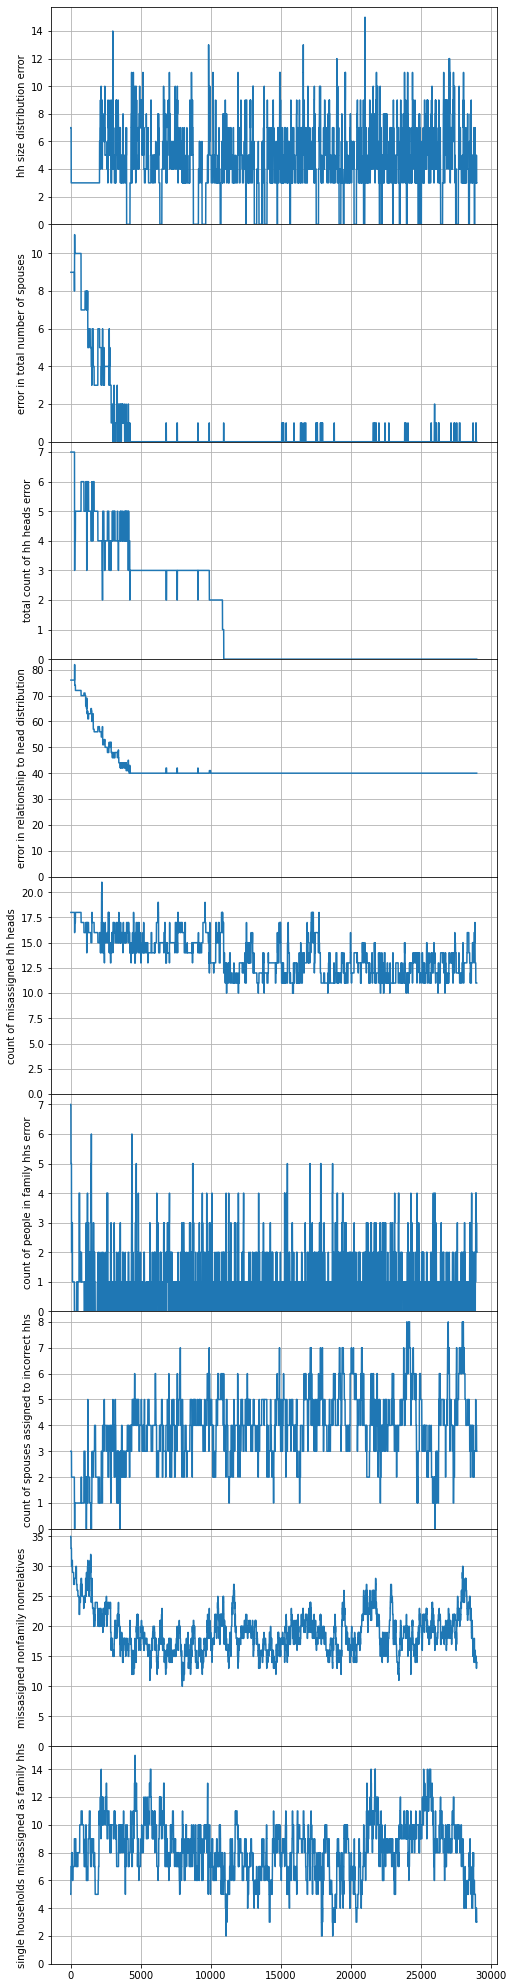

In [47]:
n = 9

fig, axs = plt.subplots(n, sharex=True, gridspec_kw={'hspace': 0}, figsize = (8,4*n))

# fig.suptitle('Trace')

k = 0

y = hh_dist_trace_full
x = np.arange(len(hh_dist_trace_full))

axs[k].plot(x,y)
axs[k].set_ylabel('hh size distribution error')
k += 1

target_spouses = ravenna_relps[ravenna_relps.relp_id==1].counts.values[0]
y = [np.abs(target_spouses - i) for i in spouse_count_trace]
x = np.arange(len(spouse_count_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('error in total number of spouses')
k += 1

target_heads = ravenna_relps[ravenna_relps.relp_id==0].counts.values[0]
y = [np.abs(target_heads - i) for i in hh_head_count_trace]
x = np.arange(len(hh_head_count_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('total count of hh heads error')
k += 1

y = np.abs(relp_dist_error_trace)
x = np.arange(len(relp_dist_error_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('error in relationship to head distribution')
k += 1

y = heads_per_hh_error
x = np.arange(len(heads_per_hh_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of misassigned hh heads')
k += 1

y = np.abs(family_hh_error)
x = np.arange(len(family_hh_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of people in family hhs error')
k += 1

y = np.abs(spouse_assign_error)
x = np.arange(len(spouse_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of spouses assigned to incorrect hhs')
k += 1

y = np.abs(nonrel_assign_error)
x = np.arange(len(nonrel_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('missasigned nonfamily nonrelatives')
k += 1

y = np.abs(single_hh_assign_error)
x = np.arange(len(single_hh_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('single households misassigned as family hhs')
k += 1

for i in range(n):
    axs[i].grid()
    axs[i].set_ylim(ymin=0)

plt.show()